In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 16, 10

# Read in data and do basic massaging

In [2]:
df_us_raw = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
df_us_raw.head(2)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,32,37,45,51,55,56,58,69,77,82


In [3]:
df_global_raw = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_global_raw.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,74,84,94,110,110,120,170,174,237,273
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,123,146,174,186,197,212,223,243,259,277


In [4]:
print(df_us_raw.columns)
print(df_global_raw.columns)

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20',
       '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20',
       '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20',
       '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20',
       '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20',
       '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20',
       '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20',
       '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20',
       '3/15/20', '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20',
       '3/21/20', '3/22/20', '3/23/20', '3/24/20', '3/25/20', '3/26/20',
       '3/27/20', '3/28/20', '3/29/20', '3/30/20', '3/31/20', '4/1/20',
       '4/2/20'],
      dtype

In [5]:
df_global_raw = df_global_raw.rename(columns={'Province/State': 'Province_State', 
                                             'Country/Region': 'Country_Region',
                                             'Long': 'Long_'})
#df_global_raw['Combined_Key'] = df_global_raw.Province_State.astype(str).str.cat(df_global_raw.Country_Region.astype(str), sep=', ', na_rep='')
df_global_raw.insert(loc=4, column='Combined_Key', value=df_global_raw.Province_State.astype(str).str.cat(df_global_raw.Country_Region.astype(str), sep=', ', na_rep=''))


df_raw = df_global_raw.append(df_us_raw)
df_raw

,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,...,3/30/20,3/31/20,4/1/20,4/2/20,UID,iso2,iso3,code3,FIPS,Admin2
0,NaN,Afghanistan,33.0000,65.0000,"nan, Afghanistan",0,0,0,0,0,...,170,174,237,273,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Albania,41.1533,20.1683,"nan, Albania",0,0,0,0,0,...,223,243,259,277,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Algeria,28.0339,1.6596,"nan, Algeria",0,0,0,0,0,...,584,716,847,986,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Andorra,42.5063,1.5218,"nan, Andorra",0,0,0,0,0,...,370,376,390,428,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,Angola,-11.2027,17.8739,"nan, Angola",0,0,0,0,0,...,7,7,8,8,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3248,Washington,US,0.0000,0.0000,"Unassigned, Washington, US",0,0,0,0,0,...,274,274,303,344,84090053.0,US,USA,840.0,90053.0,Unassigned
3249,West Virginia,US,0.0000,0.0000,"Unassigned, West Virginia, US",0,0,0,0,0,...,0,0,0,0,84090054.0,US,USA,840.0,90054.0,Unassigned
3250,Wisconsin,US,0.0000,0.0000,"Unassigned, Wisconsin, US",0,0,0,0,0,...,0,0,0,0,84090055.0,US,USA,840.0,90055.0,Unassigned
3251,Wyoming,US,0.0000,0.0000,"Unassigned, Wyoming, US",0,0,0,0,0,...,0,0,0,0,84090056.0,US,USA,840.0,90056.0,Unassigned


In [6]:
df_raw = df_raw.drop(labels=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2'], axis=1)

In [7]:
df_raw.columns

Index(['Province_State', 'Country_Region', 'Lat', 'Long_', 'Combined_Key',
       '1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20',
       '2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20', '2/9/20',
       '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20', '2/15/20',
       '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20', '2/21/20',
       '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20', '2/27/20',
       '2/28/20', '2/29/20', '3/1/20', '3/2/20', '3/3/20', '3/4/20', '3/5/20',
       '3/6/20', '3/7/20', '3/8/20', '3/9/20', '3/10/20', '3/11/20', '3/12/20',
       '3/13/20', '3/14/20', '3/15/20', '3/16/20', '3/17/20', '3/18/20',
       '3/19/20', '3/20/20', '3/21/20', '3/22/20', '3/23/20', '3/24/20',
       '3/25/20', '3/26/20', '3/27/20', '3/28/20', '3/29/20', '3/30/20',
       '3/31/20', '4/1/20', '4/2/20'],
      dtype='object')

In [8]:
#df_raw['Country_Region'].unique()

In [9]:
#df_raw['Province_State'].unique()

In [10]:
df1 = df_raw.melt(id_vars=df_raw.columns[:5], var_name='Date', value_name='Confirmed')
df1 = df1.set_index('Date')
df1

,Province_State,Country_Region,Lat,Long_,Combined_Key,Confirmed
Date,,,,,,
1/22/20,NaN,Afghanistan,33.0000,65.0000,"nan, Afghanistan",0
1/22/20,NaN,Albania,41.1533,20.1683,"nan, Albania",0
1/22/20,NaN,Algeria,28.0339,1.6596,"nan, Algeria",0
1/22/20,NaN,Andorra,42.5063,1.5218,"nan, Andorra",0
1/22/20,NaN,Angola,-11.2027,17.8739,"nan, Angola",0
...,...,...,...,...,...,...
4/2/20,Washington,US,0.0000,0.0000,"Unassigned, Washington, US",344
4/2/20,West Virginia,US,0.0000,0.0000,"Unassigned, West Virginia, US",0
4/2/20,Wisconsin,US,0.0000,0.0000,"Unassigned, Wisconsin, US",0


In [11]:
df2 = df_raw.melt(id_vars='Combined_Key', value_vars=df_raw.columns[5:], var_name='Date', value_name='Confirmed')
df2['Date'] = pd.to_datetime(df2.Date)
df2 = df2.set_index('Date')
df2

,Combined_Key,Confirmed
Date,,
2020-01-22,"nan, Afghanistan",0
2020-01-22,"nan, Albania",0
2020-01-22,"nan, Algeria",0
2020-01-22,"nan, Andorra",0
2020-01-22,"nan, Angola",0
...,...,...
2020-04-02,"Unassigned, Washington, US",344
2020-04-02,"Unassigned, West Virginia, US",0
2020-04-02,"Unassigned, Wisconsin, US",0


# Narrow down to a set of interesting States and Counties and graph

In [12]:
# just a cell to try different approaches for choosing rows
rowsofinterest = df2['Combined_Key'].isin(['Santa Clara, California, US', 'New York City, New York, US', 'Salt Lake, Utah, US'])
rowsofinterest = df2['Combined_Key'].str.endswith('California, US')
df2.loc[rowsofinterest,:].head(2)

,Combined_Key,Confirmed
Date,,
2020-01-22,"Alameda, California, US",0
2020-01-22,"Alpine, California, US",0


In [13]:
df = pd.DataFrame(index = df2.index.unique(),
                     data = {
                         'California': df2.loc[df2['Combined_Key'].str.endswith('California, US'),'Confirmed'].groupby(level=0).sum(),
                         'New York': df2.loc[df2['Combined_Key'].str.endswith('New York, US'),'Confirmed'].groupby(level=0).sum(),
                         'Washington': df2.loc[df2['Combined_Key'].str.endswith('Washington, US'),'Confirmed'].groupby(level=0).sum(),
                         'Utah': df2.loc[df2['Combined_Key'].str.endswith('Utah, US'),'Confirmed'].groupby(level=0).sum(),
                         'Hawaii': df2.loc[df2['Combined_Key'].str.endswith('Hawaii, US'),'Confirmed'].groupby(level=0).sum(),
                         'Idaho': df2.loc[df2['Combined_Key'].str.endswith('Idaho, US'),'Confirmed'].groupby(level=0).sum(),
                         'Santa Clara Co.': df2.loc[df2['Combined_Key']=='Santa Clara, California, US', 'Confirmed'].groupby(level=0).sum(),
                         'Los Angeles Co.': df2.loc[df2['Combined_Key']=='Los Angeles, California, US', 'Confirmed'].groupby(level=0).sum(),
                         'Japan': df2.loc[df2['Combined_Key'].str.endswith('Japan'),'Confirmed'].groupby(level=0).sum(),
                         'United States': df2.loc[df2['Combined_Key'].str.endswith('US'),'Confirmed'].groupby(level=0).sum(),
                         'Singapore': df2.loc[df2['Combined_Key'].str.endswith('Singapore'),'Confirmed'].groupby(level=0).sum(),
                         'Italy': df2.loc[df2['Combined_Key'].str.endswith('Italy'),'Confirmed'].groupby(level=0).sum(),
                         'Spain': df2.loc[df2['Combined_Key'].str.endswith('Spain'),'Confirmed'].groupby(level=0).sum(),
                         'Iran': df2.loc[df2['Combined_Key'].str.endswith('Iran'),'Confirmed'].groupby(level=0).sum(),
                         'France': df2.loc[df2['Combined_Key'].str.endswith('France'),'Confirmed'].groupby(level=0).sum(),
                         'Germany': df2.loc[df2['Combined_Key'].str.endswith('Germany'),'Confirmed'].groupby(level=0).sum(),
                         'Switzerland': df2.loc[df2['Combined_Key'].str.endswith('Switzerland'),'Confirmed'].groupby(level=0).sum(),
                         'United Kingdom': df2.loc[df2['Combined_Key'].str.endswith('United Kingdom'),'Confirmed'].groupby(level=0).sum(),
                         'South Korea': df2.loc[df2['Combined_Key'].str.endswith('Korea, South'),'Confirmed'].groupby(level=0).sum(),
                         'Taiwan': df2.loc[df2['Combined_Key'].str.endswith('Taiwan*'),'Confirmed'].groupby(level=0).sum(),
                         'Philippines': df2.loc[df2['Combined_Key'].str.endswith('Philippines'),'Confirmed'].groupby(level=0).sum(),
                         'Ireland': df2.loc[df2['Combined_Key'].str.endswith('Ireland'),'Confirmed'].groupby(level=0).sum(),
                         'China': df2.loc[df2['Combined_Key'].str.endswith('China'),'Confirmed'].groupby(level=0).sum(),
                     }

)
df = df.loc[~(df==0).all(axis=1)] # drop rows with all zeros
# The next two drops ensure that if the two source files are out of sync, we don't
# show the rows where there is zero data for one of them
df = df.loc[~(df['Italy']==0)] # drop rows if Italy is Zero (from global source)
df = df.loc[~(df['California']==0)] # drop rows if California is Zero (from US source)
df = df.loc['2/1/20':,:]
df

,California,New York,Washington,Utah,Hawaii,Idaho,Santa Clara Co.,Los Angeles Co.,Japan,United States,...,Iran,France,Germany,Switzerland,United Kingdom,South Korea,Taiwan,Philippines,Ireland,China
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-01,3,0,1,0,0,0,1,1,20,16,...,0,6,8,0,2,12,10,1,0,11891
2020-02-02,3,0,1,0,0,0,1,1,20,16,...,0,6,10,0,2,15,10,2,0,16630
2020-02-03,6,0,1,0,0,0,2,1,20,22,...,0,6,12,0,2,15,10,2,0,19716
2020-02-04,6,0,1,0,0,0,2,1,22,22,...,0,6,12,0,2,16,11,2,0,23707
2020-02-05,6,0,1,0,0,0,2,1,22,22,...,0,6,12,0,2,19,11,2,0,27440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-29,5852,59648,4465,675,149,281,646,1829,1866,281772,...,38309,40708,62095,14829,19780,9583,298,1418,2615,82122
2020-03-30,7138,66663,4923,750,175,340,848,2474,1866,323614,...,41495,45170,66885,15922,22453,9661,306,1546,2910,82198
2020-03-31,8210,75833,5432,833,204,515,890,3019,1953,376344,...,44605,52827,71808,16605,25481,9786,322,2084,3235,82279


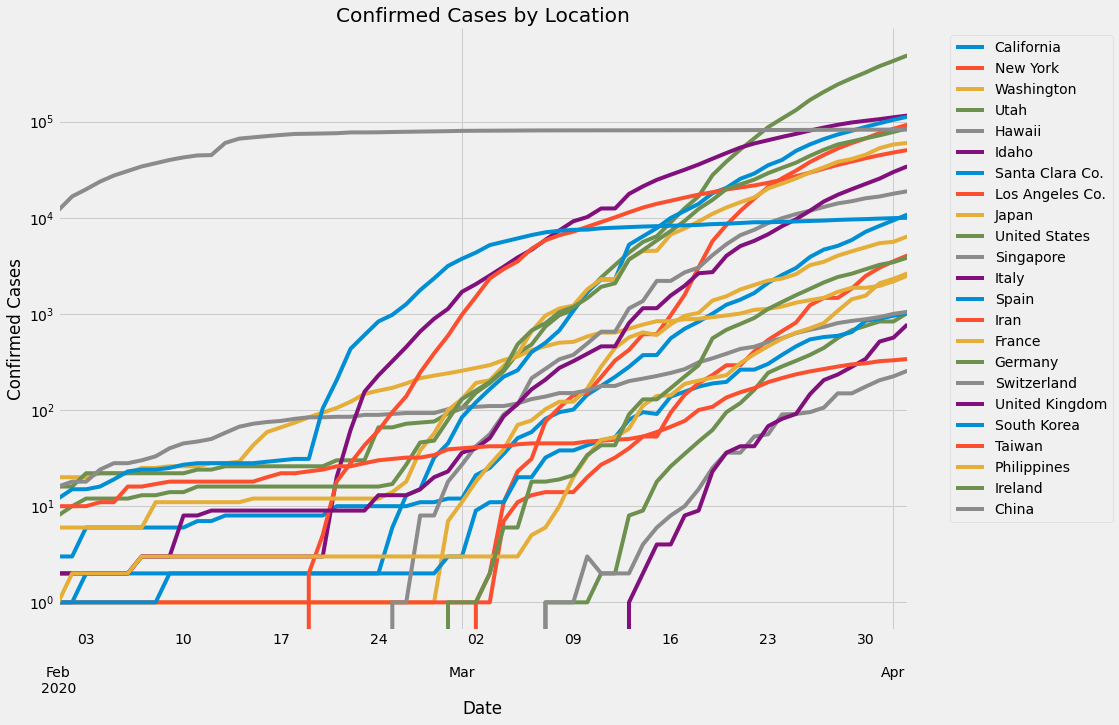

In [14]:
#newdf.loc['2/1/20':,:].plot(logy=True)
df.plot(logy=True)
plt.legend(bbox_to_anchor=(1.25, 1))
plt.tight_layout()
plt.title("Confirmed Cases by Location")
plt.ylabel("Confirmed Cases")
sns.despine()

# TEMP ONLY
Drop rows that have data glitches

In [15]:
#df = df.drop(labels=['3/22/20', '3/30/20'], axis=0)

# Graph raw data

### label_lines routine

In [16]:
def label_lines(df, ax, tuple_selector=None, print_value=False):
    '''Labels lines in a chart assuming that some lines will be different lengths than others
       If tuple_selector is set to an integer, use it as an index to the label'''
    for label, series in df.items():
        prev_x = series.index[0]
        prev_data = series.iloc[0]
        for index, data in series.items():
            if pd.isnull(data):
                break
            prev_x = index
            prev_data = data
        if tuple_selector:
            if print_value:
                label = '{} ({:,})'.format(label[tuple_selector], int(prev_data))
            else:
                label = label[tuple_selector]
        else:
            if print_value:
                label = '{} ({:,})'.format(label, int(prev_data))
        ax.annotate(label, (prev_x, prev_data),
                            xytext=(10,0), 
                            textcoords='offset pixels',
                            family='sans-serif', fontsize=14, color='darkslategrey')

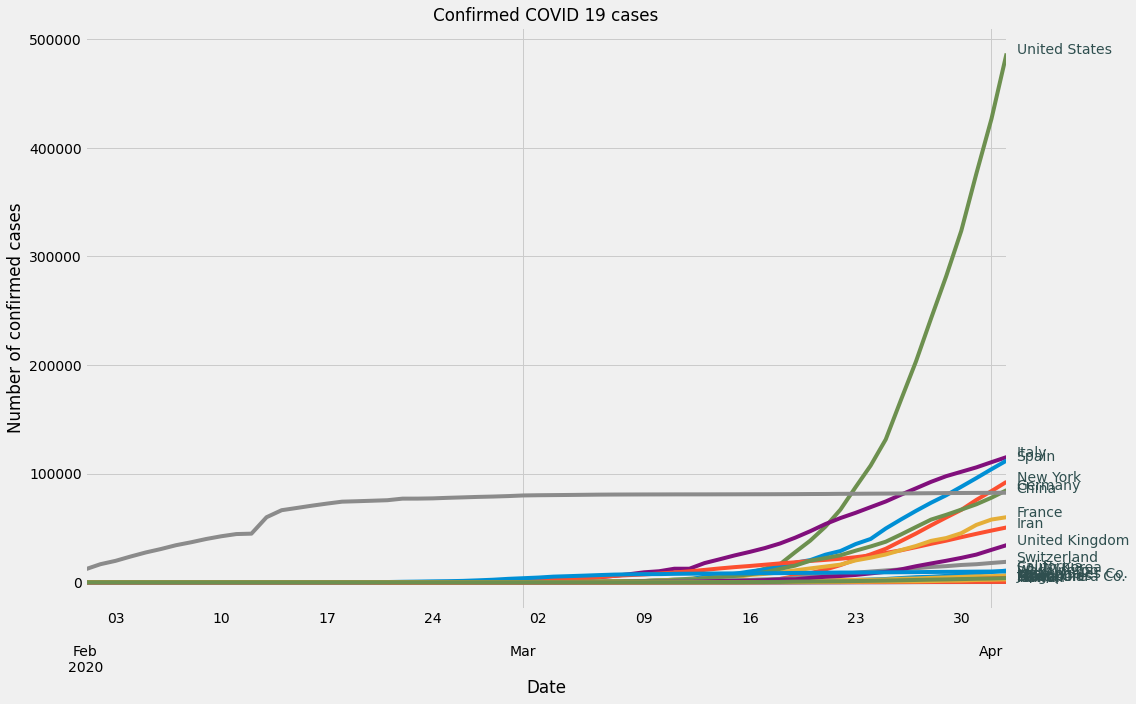

In [17]:
  
graph_data = df
#graph_data = df.drop('China', axis=1).loc['2/21/20':,:]
ax = graph_data.plot(legend=False)
ax.set_title('Confirmed COVID 19 cases', fontsize='large')
ax.set_ylabel('Number of confirmed cases', fontsize='large')
label_lines(graph_data, ax)
plt.tight_layout()
plt.show()

# Create a 'days since 100 cases' graph

In [18]:
df.tail(2)

,California,New York,Washington,Utah,Hawaii,Idaho,Santa Clara Co.,Los Angeles Co.,Japan,United States,...,Iran,France,Germany,Switzerland,United Kingdom,South Korea,Taiwan,Philippines,Ireland,China
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-01,9399,83948,5608,833,224,566,956,3518,2178,426734,...,47593,57749,77872,17768,29865,9887,329,2311,3447,82361
2020-04-02,10773,92506,6389,1021,256,776,1019,4045,2495,486906,...,50468,59929,84794,18827,34173,9976,339,2633,3849,82432


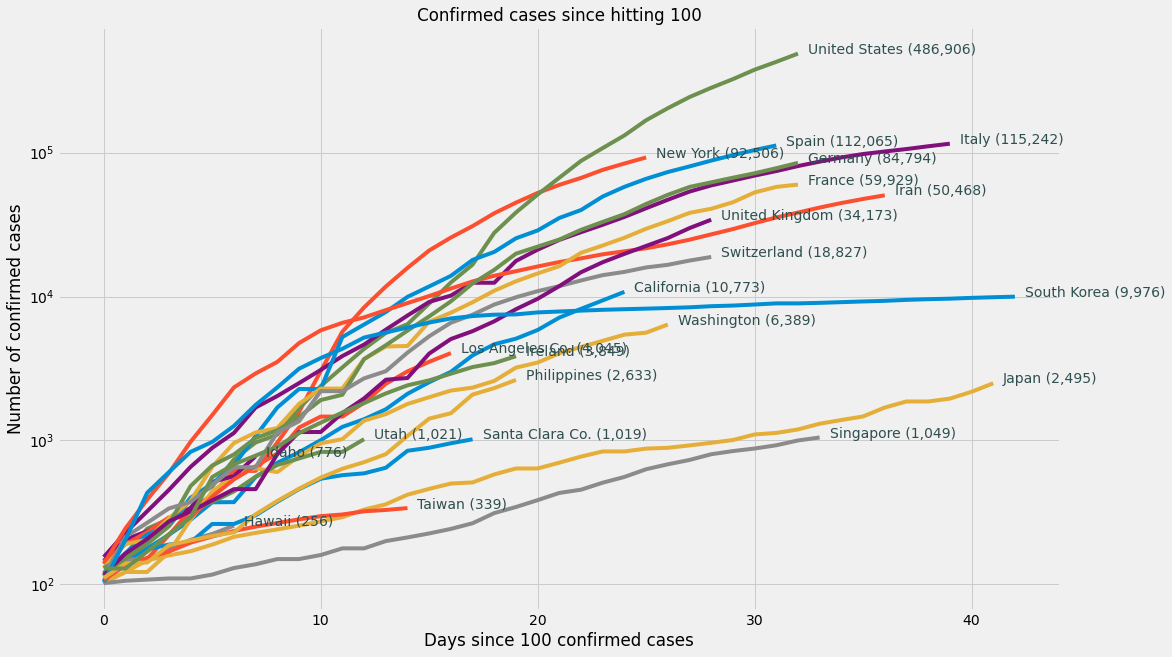

In [21]:
threshold = 100
daysSince100 = pd.DataFrame(index=range(0,len(df.index)))
for location in df.columns:
    # create list of data once above 'threshold'
    tempList = [df.loc[date, location] 
                              for date in df[location].index 
                              if df.loc[date, location] > threshold]
    if (not tempList) or (tempList[-1] <= threshold):
        continue
    # put that list in another list that has NaN's buffered out to length of the DataFrame
    tempListFilled = list()
    for index, _ in enumerate(daysSince100.index):
        if index < len(tempList):
            tempListFilled.append(tempList[index])
        else:
            tempListFilled.append(np.NaN)
    # add the buffered list to the dataframe as a new column
    daysSince100[location] = tempListFilled

daysSince100 = daysSince100.drop('China', axis=1)
daysSince100 = daysSince100.dropna(axis=0, how='all')
ax = daysSince100.plot(logy=True, legend=False)
#ax.set_yscale('log', basey=2)
ax.set_title('Confirmed cases since hitting {}'.format(threshold), fontsize='large')
ax.set_xlabel('Days since {} confirmed cases'.format(threshold), fontsize='large')
ax.set_ylabel('Number of confirmed cases', fontsize='large')
#ax.annotate("Italy on 3/14", xy=(20,21157), xytext=(15, 30000),
#            arrowprops=dict(facecolor='grey', shrink=0.05),)

label_lines(daysSince100, ax, print_value=True)
    
#ax.hlines(60461826, 0, 50, linestyles='dotted', label='Pop of Italy')
plt.show()
        

# Cases relative to Population

In [22]:
per = 100000

popdf = pd.DataFrame(index = df.index,
                     data = {
                         'California': 39747267,
                         'New York': 19491339,
                         'Washington': 7797095,
                         'Utah': 3282115,
                         'Hawaii': 1412687,
                         'Idaho': 1826156,
                         'Santa Clara Co.': 2200000,
                         'Los Angeles Co.': 10500000,
                         'Japan': 126476461,
                         'United States': 331002651,
                         'Singapore': 5850342,
                         'Italy': 60461826,
                         'Spain': 46754778,
                         'Iran': 83992949,
                         'France': 65273511,
                         'Germany': 83783942,
                         'Switzerland': 8654622,
                         'United Kingdom': 67886011,
                         'South Korea': 51269185,
                         'Taiwan': 23816775,
                         'Philippines': 109581078,
                         'Ireland': 4937786,
                         'China': 1439323776,
                         
                     }

)
popdf

casesperdf = df.div(popdf).mul(per)
casesperdf.tail()

,California,New York,Washington,Utah,Hawaii,Idaho,Santa Clara Co.,Los Angeles Co.,Japan,United States,...,Iran,France,Germany,Switzerland,United Kingdom,South Korea,Taiwan,Philippines,Ireland,China
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-29,14.723025,306.023101,57.264917,20.566007,10.547276,15.387513,29.363636,17.419048,1.475373,85.126811,...,45.609781,62.365268,74.113247,171.341972,29.137078,18.691540,1.251219,1.294019,52.958958,5.705596
2020-03-30,17.958467,342.013445,63.138900,22.851119,12.387741,18.618344,38.545455,23.561905,1.475373,97.767797,...,49.402956,69.201119,79.830333,183.971062,33.074561,18.843678,1.284809,1.410828,58.933295,5.710876
2020-03-31,20.655508,389.059982,69.666972,25.379976,14.440566,28.201315,40.454545,28.752381,1.544161,113.698183,...,53.105648,80.931758,85.706161,191.862799,37.534979,19.087489,1.351988,1.901788,65.515192,5.716504
2020-04-01,23.646909,430.693858,71.924223,25.379976,15.856308,30.994066,43.454545,33.504762,1.722060,128.921626,...,56.663090,88.472336,92.943824,205.300705,43.992863,19.284488,1.381379,2.108941,69.808615,5.722201
2020-04-02,27.103750,474.600539,81.940774,31.107990,18.121495,42.493631,46.318182,38.523810,1.972699,147.100332,...,60.085996,91.812129,101.205551,217.536942,50.338795,19.458082,1.423367,2.402787,77.949915,5.727134


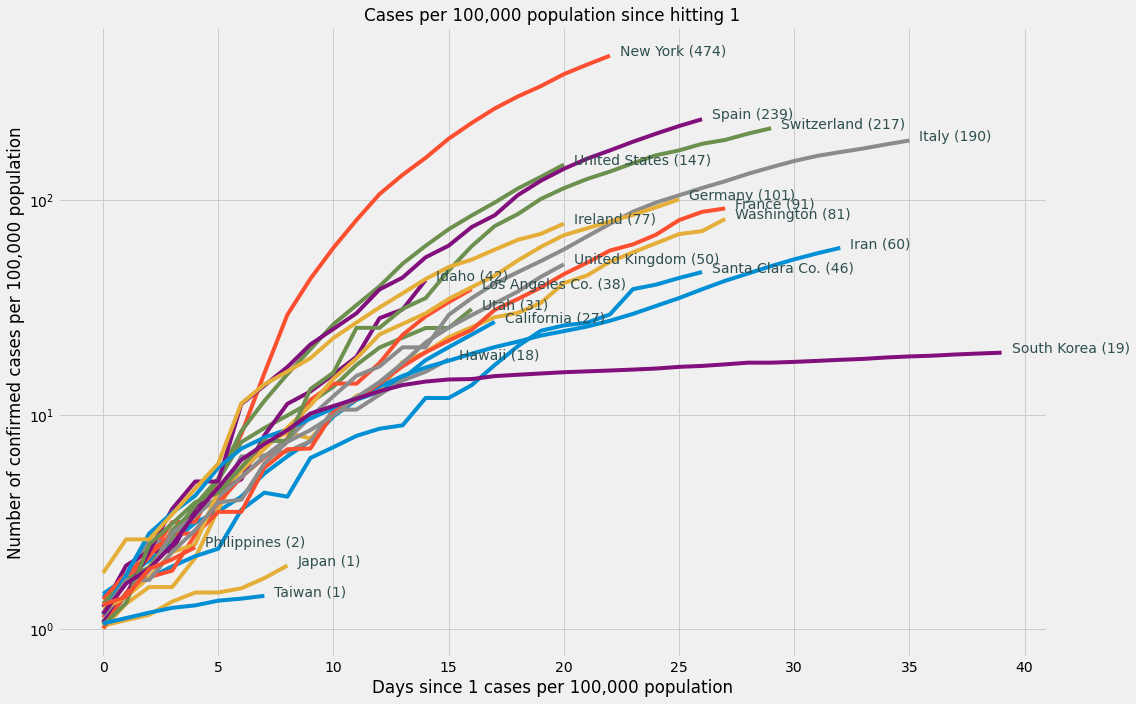

In [23]:
threshold = 1
daysSincerate = pd.DataFrame(index=range(0,len(casesperdf.index)))
for location in casesperdf.columns:
    # create list of data once above 'threshold'
    tempList = [casesperdf.loc[date, location] 
                              for date in casesperdf[location].index 
                              if casesperdf.loc[date, location] > threshold]
    if (not tempList) or (tempList[-1] <= threshold):
        continue
    # put that list in another list that has NaN's buffered out to length of the DataFrame
    tempListFilled = list()
    for index, _ in enumerate(daysSincerate.index):
        if index < len(tempList):
            tempListFilled.append(tempList[index])
        else:
            tempListFilled.append(np.NaN)
    # add the buffered list to the dataframe as a new column
    daysSincerate[location] = tempListFilled


daysSincerate = daysSincerate.drop(['China','Singapore'], axis=1)
daysSincerate = daysSincerate.dropna(axis=0, how='all')
ax = daysSincerate.plot(logy=True, legend=False)
#ax.set_yscale('log', basey=2)
ax.set_title('Cases per {:,} population since hitting {}'.format(per, threshold), fontsize='large')
ax.set_xlabel('Days since {} cases per {:,} population'.format(threshold, per), fontsize='large')
ax.set_ylabel('Number of confirmed cases per {:,} population'.format(per), fontsize='large')
#ax.annotate("Italy on 3/14", xy=(16,34.99), xytext=(25, 24),
#            arrowprops=dict(facecolor='grey', shrink=0.05),)

label_lines(daysSincerate, ax, print_value=True)

plt.tight_layout()
plt.show()
        

In [24]:
daysSince100

,California,New York,Washington,Utah,Hawaii,Idaho,Santa Clara Co.,Los Angeles Co.,Japan,United States,...,Spain,Iran,France,Germany,Switzerland,United Kingdom,South Korea,Taiwan,Philippines,Ireland
0,101.0,106.0,102.0,118.0,106.0,146.0,138.0,144.0,105.0,104.0,...,120.0,139.0,130.0,130.0,114.0,116.0,104.0,108.0,111.0,129.0
1,144.0,142.0,122.0,162.0,149.0,205.0,155.0,190.0,122.0,151.0,...,165.0,245.0,191.0,159.0,214.0,164.0,204.0,135.0,140.0,129.0
2,178.0,150.0,122.0,244.0,149.0,234.0,175.0,231.0,147.0,191.0,...,222.0,388.0,204.0,196.0,268.0,207.0,433.0,153.0,142.0,169.0
3,221.0,220.0,167.0,284.0,175.0,281.0,189.0,292.0,159.0,253.0,...,259.0,593.0,288.0,262.0,337.0,274.0,602.0,169.0,187.0,223.0
4,281.0,327.0,282.0,325.0,204.0,340.0,196.0,292.0,170.0,389.0,...,400.0,978.0,380.0,482.0,374.0,322.0,833.0,195.0,202.0,292.0
5,372.0,421.0,442.0,374.0,224.0,515.0,263.0,407.0,189.0,479.0,...,500.0,1501.0,656.0,670.0,491.0,384.0,977.0,215.0,217.0,557.0
6,373.0,613.0,568.0,443.0,256.0,566.0,263.0,536.0,214.0,738.0,...,673.0,2336.0,959.0,799.0,652.0,459.0,1261.0,235.0,230.0,683.0
7,557.0,615.0,642.0,560.0,NaN,776.0,302.0,662.0,228.0,968.0,...,1073.0,2922.0,1136.0,1040.0,652.0,459.0,1766.0,252.0,307.0,785.0
8,700.0,967.0,603.0,675.0,NaN,NaN,375.0,812.0,241.0,1097.0,...,1695.0,3513.0,1219.0,1176.0,1139.0,802.0,2337.0,267.0,380.0,906.0
9,828.0,1578.0,779.0,750.0,NaN,NaN,459.0,1229.0,256.0,1667.0,...,2277.0,4747.0,1794.0,1457.0,1359.0,1144.0,3150.0,283.0,462.0,1125.0


# Look at growth factor changes

In [23]:
start_date = '3/22/20'
location = ['California', 'Italy', 'New York']
#location = ['California', 'South Korea', 'Italy', 'Germany', 'New York']
df.loc[start_date:,:]

,California,New York,Washington,Utah,Hawaii,Idaho,Santa Clara Co.,Los Angeles Co.,Japan,United States,...,Iran,France,Germany,Switzerland,United Kingdom,South Korea,Taiwan,Philippines,Ireland,China
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-22,1646,15800,1997,162,53,42,263,407,1101,66897,...,21638,16243,24873,7474,5745,8961,169,380,906,81435
2020-03-23,2108,20884,2221,244,56,68,302,536,1128,87510,...,23049,20123,29056,8795,6726,8961,195,462,1125,81498
2020-03-24,2538,25681,2328,284,90,81,375,662,1193,107476,...,24811,22622,32986,9877,8164,9037,215,552,1329,81591
2020-03-25,2998,30841,2591,325,91,91,459,812,1307,131556,...,27017,25600,37323,10897,9640,9137,235,636,1564,81661
2020-03-26,3899,37877,3207,374,95,146,542,1229,1387,167672,...,29406,29551,43938,11811,11812,9241,252,707,1819,81782
2020-03-27,4657,44876,3477,443,106,205,574,1465,1468,203314,...,32332,33402,50871,12928,14745,9332,267,803,2121,81897
2020-03-28,5095,52410,4030,560,149,234,591,1465,1693,242956,...,35408,38105,57695,14076,17312,9478,283,1075,2415,81999
2020-03-29,5852,59648,4465,675,149,281,646,1829,1866,281772,...,38309,40708,62095,14829,19780,9583,298,1418,2615,82122
2020-03-30,7138,66663,4923,750,175,340,848,2474,1866,323614,...,41495,45170,66885,15922,22453,9661,306,1546,2910,82198


In [24]:
# calculate growth factor (diff between 2 points divided by the diff between the prior 2 points)
df.loc[start_date:,:].diff().pct_change().add(1)

,California,New York,Washington,Utah,Hawaii,Idaho,Santa Clara Co.,Los Angeles Co.,Japan,United States,...,Iran,France,Germany,Switzerland,United Kingdom,South Korea,Taiwan,Philippines,Ireland,China
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-24,0.930736,0.943548,0.477679,0.487805,11.333333,0.500000,1.871795,0.976744,2.407407,0.968612,...,1.248760,0.644072,0.939517,0.819076,1.465851,inf,0.769231,1.097561,0.931507,1.476190
2020-03-25,1.069767,1.075672,2.457944,1.025000,0.029412,0.769231,1.150685,1.190476,1.753846,1.206050,...,1.251986,1.191677,1.103562,0.942699,1.026426,1.315789,1.000000,0.933333,1.151961,0.752688
2020-03-26,1.958696,1.363566,2.342205,1.195122,4.000000,5.500000,0.988095,2.780000,0.701754,1.499834,...,1.082956,1.326729,1.525248,0.896078,1.471545,1.040000,0.850000,0.845238,1.085106,1.728571
2020-03-27,0.841287,0.994741,0.438312,1.408163,2.750000,1.072727,0.385542,0.565947,1.012500,0.986876,...,1.224780,0.974690,1.048073,1.222101,1.350368,0.875000,0.882353,1.352113,1.184314,0.950413
2020-03-28,0.577836,1.076439,2.048148,1.695652,3.909091,0.491525,0.531250,0.000000,2.777778,1.112227,...,1.051265,1.221241,0.984278,1.027753,0.875213,1.604396,1.066667,2.833333,0.973510,0.886957
2020-03-29,1.728311,0.960711,0.786618,0.982906,0.000000,1.620690,3.235294,inf,0.768889,0.979164,...,0.943108,0.553477,0.644783,0.655923,0.961434,0.719178,0.937500,1.261029,0.680272,1.205882
2020-03-30,1.698811,0.969190,1.052874,0.652174,inf,1.255319,3.672727,1.771978,0.000000,1.077958,...,1.098242,1.714176,1.088636,1.451527,1.083063,0.742857,0.533333,0.373178,1.475000,0.617886


In [25]:
# Many countries didn't update their reports on 3/12 leading to 'inf' growth
# factor on 3/13.  I'm going to drop 3/12 data to get a better trend
#tempdf = df.drop('3/12/20', axis='index')
tempdf = df
tempdf.loc[start_date:,:].diff().pct_change().add(1)

,California,New York,Washington,Utah,Hawaii,Idaho,Santa Clara Co.,Los Angeles Co.,Japan,United States,...,Iran,France,Germany,Switzerland,United Kingdom,South Korea,Taiwan,Philippines,Ireland,China
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-24,0.930736,0.943548,0.477679,0.487805,11.333333,0.500000,1.871795,0.976744,2.407407,0.968612,...,1.248760,0.644072,0.939517,0.819076,1.465851,inf,0.769231,1.097561,0.931507,1.476190
2020-03-25,1.069767,1.075672,2.457944,1.025000,0.029412,0.769231,1.150685,1.190476,1.753846,1.206050,...,1.251986,1.191677,1.103562,0.942699,1.026426,1.315789,1.000000,0.933333,1.151961,0.752688
2020-03-26,1.958696,1.363566,2.342205,1.195122,4.000000,5.500000,0.988095,2.780000,0.701754,1.499834,...,1.082956,1.326729,1.525248,0.896078,1.471545,1.040000,0.850000,0.845238,1.085106,1.728571
2020-03-27,0.841287,0.994741,0.438312,1.408163,2.750000,1.072727,0.385542,0.565947,1.012500,0.986876,...,1.224780,0.974690,1.048073,1.222101,1.350368,0.875000,0.882353,1.352113,1.184314,0.950413
2020-03-28,0.577836,1.076439,2.048148,1.695652,3.909091,0.491525,0.531250,0.000000,2.777778,1.112227,...,1.051265,1.221241,0.984278,1.027753,0.875213,1.604396,1.066667,2.833333,0.973510,0.886957
2020-03-29,1.728311,0.960711,0.786618,0.982906,0.000000,1.620690,3.235294,inf,0.768889,0.979164,...,0.943108,0.553477,0.644783,0.655923,0.961434,0.719178,0.937500,1.261029,0.680272,1.205882
2020-03-30,1.698811,0.969190,1.052874,0.652174,inf,1.255319,3.672727,1.771978,0.000000,1.077958,...,1.098242,1.714176,1.088636,1.451527,1.083063,0.742857,0.533333,0.373178,1.475000,0.617886


Text(0.5, 1.0, 'Confirmed Cases Growth Factor\n(Daily change in confirmed cases divided by previous daily change)\n(2 day moving average)')

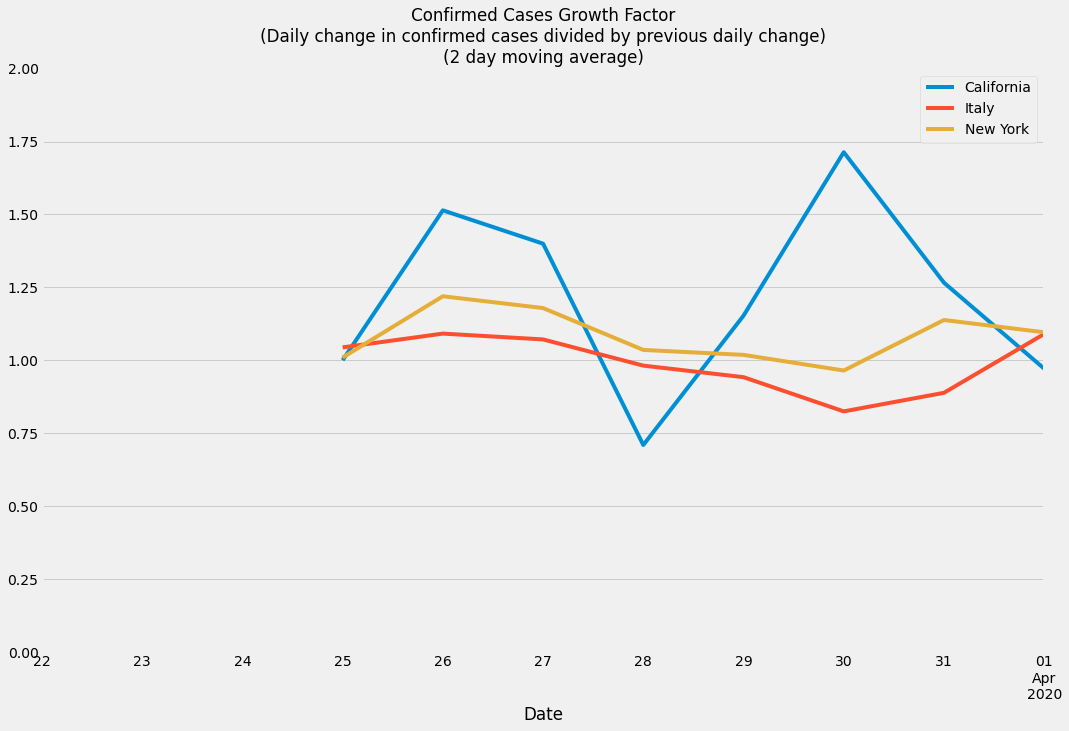

In [26]:
# graph the growth factors
window = 2
ax = tempdf.loc[start_date:,location].diff().pct_change().add(1).rolling(window).mean().plot()
ax.set_ylim(ymin=0, ymax=2)
ax.set_title("Confirmed Cases Growth Factor\n(Daily change in confirmed cases divided by previous daily change)\n({} day moving average)".format(window), fontsize='large')